# Deep Learning for NLP - Project

RULES:

* Do not create any additional cell

* Fill in the blanks

* All cells should be runnable (modulo trivial compatibility bugs that we'd fix)

* 4 / 20 points will be allocated to the clarity of your code

* Efficient code will have a bonus

DELIVERABLE:

* this notebook
* the predictions of the SST test set

DO NOT INCLUDE THE DATASETS IN THE DELIVERABLE..

In [1]:
import io
import os
import numpy as np
import scipy
import operator
import math

In [2]:
PATH_TO_DATA = "/Users/Jean/Desktop/Deep Learning/nlp_project/data/"

# 1) Monolingual (English) word embeddings 

In [3]:
class Word2vec():
    def __init__(self, fname, nmax=100000):
        self.load_wordvec(fname, nmax)
        self.word2id = dict.fromkeys(self.word2vec.keys())
        self.id2word = {v: k for k, v in self.word2id.items()}
        self.embeddings = np.array(self.word2vec.values())
    
    def load_wordvec(self, fname, nmax):
        self.word2vec = {}
        with io.open(fname, encoding='utf-8') as f:
            next(f)
            for i, line in enumerate(f):
                word, vec = line.split(' ', 1)
                self.word2vec[word] = np.fromstring(vec, sep=' ')
                if i == (nmax - 1):
                    break
        print('Loaded %s pretrained word vectors' % (len(self.word2vec)))

    def most_similar(self, w, k=5):
        # k most similar words: self.score  -  np.argsort
        trainingSet = list(self.word2vec.keys())
        distances = []
        for x in range(len(trainingSet)):
            dist = self.score(w, trainingSet[x])
            distances.append((trainingSet[x], dist))
        distances.sort(key=operator.itemgetter(1), reverse=True)
        neighbors = []
        for x in range(1, k+1):
            neighbors.append(distances[x][0])
        return neighbors

    def score(self, w1, w2):
        # cosine similarity: np.dot  -  np.linalg.norm
        v1 = self.word2vec[w1]
        v2 = self.word2vec[w2]
        x = np.dot(v1, v2)/(np.linalg.norm(v1)*np.linalg.norm(v2))
        return x


In [4]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=60000)

# You will be evaluated on the output of the following:
for w1, w2 in zip(('cat', 'dog', 'dogs', 'paris', 'germany'), ('dog', 'pet', 'cats', 'france', 'berlin')):
    print(w1, w2, w2v.score(w1, w2))
for w1 in ['cat', 'dog', 'dogs', 'paris', 'germany']:
    print(w2v.most_similar(w1))

Loaded 60000 pretrained word vectors
cat dog 0.6716836662792491
dog pet 0.6842064029669219
dogs cats 0.7074389328052404
paris france 0.7775108541288561
germany berlin 0.7420295235998392
['cats', 'kitty', 'kitten', 'feline', 'kitties']
['dogs', 'puppy', 'Dog', 'doggie', 'canine']
['dog', 'Dogs', 'doggies', 'canines', 'puppies']
['france', 'Paris', 'london', 'berlin', 'europe']
['europe', 'german', 'berlin', 'france', 'italy']


In [4]:
class BoV():
    def __init__(self, w2v):
        self.w2v = w2v
        #self.idf = self.build_idf(sentences)
    
    def encode(self, sentences, idf=False):
        # takes a list of sentences, outputs a numpy array of sentence embeddings
        # see TP1 for help
        sentemb = []
        idf_dict = self.build_idf(sentences) 
        #return
        for sent in sentences:
            if idf is False:
                # mean of word vectors
                sentemb.append(np.mean([w2v.word2vec[w] for w in sent if w in w2v.word2vec], axis=0))
                #assert False, 'TODO: fill in the blank'
            else:
                # idf-weighted mean of word vectors
                sentemb.append(np.average([w2v.word2vec[w] for w in sent if w in w2v.word2vec], 
                                          axis=0, weights=[idf_dict[w] for w in sent if w in w2v.word2vec]))
                #assert False, 'TODO: fill in the blank'
        return np.vstack(sentemb)

    def most_similar(self, s, sentences, idf=False, k=5):
        # get most similar sentences and **print** them
        #keys = self.encode(sentences, idf)
        #query = self.encode([s], idf)
        # k most similar words: self.score  -  np.argsort 
        distances = []
        for x in range(len(sentences)):
            dist = self.score(s, sentences[x])
            distances.append((sentences[x], dist))
        distances.sort(key=operator.itemgetter(1), reverse=True)
        neighbors = []
        for x in range(1, k+1):
            neighbors.append(distances[x][0])
        print([" ".join(neighbors[i]) for i in range(len(neighbors))])

    def score(self, s1, s2, idf=False):
        # cosine similarity: use   np.dot  and  np.linalg.norm
        s1 = self.encode([s1]).reshape(300) #change that
        s2 = self.encode([s2]).reshape(300)
        x = np.dot(s1, s2)/(np.linalg.norm(s1)*np.linalg.norm(s2))
        return x
    
    def build_idf(self, sentences):
        # build the idf dictionary: associate each word to its idf value
        idf = {}
        for sent in sentences:
            for w in set(sent):
                idf[w] = idf.get(w, 0) + 1

        for word in idf.keys():
            idf[word] = max(1, np.log10(len(sentences) / (idf[word])))
        
        return idf


In [6]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=10000)
s2v = BoV(w2v)

# Load sentences in "PATH_TO_DATA/sentences.txt"
sentences = []
with open(PATH_TO_DATA + 'data/sentences.txt') as f:
    for i, line in enumerate(f):
        sent = line.rstrip().split()
        sentences.append(sent)
print('Found %s sentences' % len(sentences))

# Build idf scores for each word
idf = False

# You will be evaluated on the output of the following:
s2v.most_similar('' if not sentences else sentences[10], sentences, idf)  # BoV-mean
print(s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13], idf))

idf = True
s2v.most_similar('' if not sentences else sentences[10], sentences, idf)  # BoV-idf
print(s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13], idf))

Loaded 10000 pretrained word vectors
Found 150736 sentences
['girl smiling on roller coaster .', 'a boy smiles underwater .', 'two girlfriends smiling .', 'a smiling child swims .', 'a small boy in goggles smiling .']
0.593603544417741
['girl smiling on roller coaster .', 'a boy smiles underwater .', 'two girlfriends smiling .', 'a smiling child swims .', 'a small boy in goggles smiling .']
0.593603544417741


# 2) Multilingual (English-French) word embeddings

Let's consider a bilingual dictionary of size V_a (e.g French-English).

Let's define **X** and **Y** the **French** and **English** matrices.

They contain the embeddings associated to the words in the bilingual dictionary.

We want to find a **mapping W** that will project the source word space (e.g French) to the target word space (e.g English).

Procrustes : **W\* = argmin || W.X - Y ||  s.t  W^T.W = Id**
has a closed form solution:
**W = U.V^T  where  U.Sig.V^T = SVD(Y.X^T)**

In what follows, you are asked to: 

In [7]:
# 1 - Download and load 50k first vectors of
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.vec
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.fr.vec

# TYPE CODE HERE

def load_wordvec(fname, nmax):
    word2vec = {}
    with io.open(fname, encoding='utf-8') as f:
        next(f)
        for i, line in enumerate(f):
            word, vec = line.split(' ', 1)
            word2vec[word] = np.fromstring(vec, sep=' ')
            if i == (nmax - 1):
                break
    print('Loaded %s pretrained word vectors' % (len(word2vec)))
    return word2vec
        
fr_dict = load_wordvec(os.path.join(PATH_TO_DATA, 'wiki.fr.vec'), nmax=50000)
en_dict = load_wordvec(os.path.join(PATH_TO_DATA, 'wiki.en.vec'), nmax=50000)

Loaded 50000 pretrained word vectors
Loaded 50000 pretrained word vectors


In [10]:
# 2 - Get words that appear in both vocabs (= identical character strings)
#     Use it to create the matrix X and Y (of aligned embeddings for these words)

# TYPE CODE HERE

common = list(set(list(fr_dict)).intersection(list(en_dict)))
len(common)

X = [fr_dict[x] for x in common]
Y = [en_dict[x] for x in common]

In [11]:
# 3 - Solve the Procrustes using the scipy package and: scipy.linalg.svd() and get the optimal W
#     Now W*French_vector is in the same space as English_vector

# TYPE CODE HERE

# W = U.V^T where U.Sig.V^T = SVD(Y.X^T)

from scipy.linalg import svd
temp = np.dot(np.transpose(np.matrix(X)), np.matrix(Y))
U, s, Vh = svd(temp)
W = np.dot(U, Vh)

In [12]:
# 4 - After alignment with W, give examples of English nearest neighbors of some French words (and vice versa)
#     You will be evaluated on that part and the code above

# TYPE CODE HERE

# update fr_dict
X_new = np.matrix(list(fr_dict.values()))
X_new = np.dot(X_new, W)
X_new = [X_new[i].tolist()[0] for i in range(len(X_new))]
new_fr_dict = dict(zip(list(fr_dict.keys()), X_new))

def most_similar(trainingSet, testInstance, k=5):
    distances = []
    for x in range(len(trainingSet)):
        dist = score(testInstance, trainingSet[x])
        distances.append((trainingSet[x], dist))
    distances.sort(key=operator.itemgetter(1), reverse=True)
    neighbors = []
    for x in range(k):
        neighbors.append(distances[x][0])
    return neighbors

# French to English

def score(w1, w2):
    # cosine similarity: np.dot  -  np.linalg.norm
    v1 = new_fr_dict[w1]
    v2 = en_dict[w2]
    x = np.dot(v1, v2)/(np.linalg.norm(v1)*np.linalg.norm(v2))
    return x

for w1 in ['maman']:
    print(most_similar(list(en_dict.keys()), w1))

# English to French

def score(w1, w2):
    # cosine similarity: np.dot  -  np.linalg.norm
    v1 = en_dict[w1]
    v2 = new_fr_dict[w2]
    x = np.dot(v1, v2)/(np.linalg.norm(v1)*np.linalg.norm(v2))
    return x
    
for w1 in ['dog']:
    print(most_similar(list(new_fr_dict.keys()), w1))

['grandma', 'mom', 'mommy', 'mama', 'baby']
['dog', 'chien', 'hound', 'chiens', 'chienne']


If you want to dive deeper on this subject: https://github.com/facebookresearch/MUSE

# 3) Sentence classification with BoV and scikit-learn

In [13]:
# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)

# TYPE CODE HERE

w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=10000)
s2v = BoV(w2v)


# Load train sentences in "PATH_TO_DATA/sentences.txt"
sentences = []
with open(PATH_TO_DATA + 'SST/stsa.fine.train.txt') as f:
    for i, line in enumerate(f):
        sent = line.rstrip().split()
        sentences.append(sent)
print('Found %s sentences' % len(sentences))

# Get senetences without target
target = [sentences[i][0] for i in range(len(sentences))]
sentences = [sentences[i][1:] for i in range(len(sentences))]

# Load dev sentences in "PATH_TO_DATA/sentences.txt"
dev_sent = []
with open(PATH_TO_DATA + 'SST/stsa.fine.dev.txt') as f:
    for i, line in enumerate(f):
        sent = line.rstrip().split()
        dev_sent.append(sent)
print('Found %s sentences' % len(dev_sent))

# Get senetences without target
dev_target = [dev_sent[i][0] for i in range(len(dev_sent))]
dev_sent = [dev_sent[i][1:] for i in range(len(dev_sent))]


# Load test sentences in "PATH_TO_DATA/sentences.txt"
test_sent = []
with open(PATH_TO_DATA + 'SST/stsa.fine.test.txt') as f:
    for i, line in enumerate(f):
        sent = line.rstrip().split()
        test_sent.append(sent)
print('Found %s sentences' % len(test_sent))

Loaded 10000 pretrained word vectors
Found 8544 sentences
Found 1101 sentences
Found 2210 sentences


In [48]:
# 2 - Encode sentences with the BoV model above

# TYPE CODE HERE

idf = False
encoded = s2v.encode(sentences, idf)
dev_encoded = s2v.encode(dev_sent, idf)
test_encoded = s2v.encode(test_sent, idf)

In [49]:
# 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
#     (consider tuning the L2 regularization on the dev set)

# TYPE CODE HERE

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import accuracy_score

def compute_score(clf, X, y, scoring='accuracy'):
    xval = cross_val_score(clf, X, y, cv=5, scoring=scoring)
    return np.mean(xval)

# format to numpy
X = np.array(encoded)
X_dev = np.array(dev_encoded)
X_test = np.array(test_encoded)
y = np.array(target).astype(int)
y_dev = np.array(dev_target).astype(int)

logistic = LogisticRegression(multi_class='multinomial', solver='lbfgs', C=1.0) #'lbfgs' 'sag' 'saga' 'newton-cg'
logistic.fit(X, y)
print("Cross-validation accuracy score: " + str(compute_score(logistic, X, y, scoring='accuracy')))

# get training error
from sklearn.metrics import mean_squared_error
y_pred = logistic.predict(X)
print("Training MSE: " + str(mean_squared_error(y, y_pred)))

Cross-validation accuracy score: 0.3974732182312716
Training MSE: 1.409878277153558


In [50]:
# 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
#     Attach the output file "logreg_bov_y_test_sst.txt" to your deliverable.
#     You will be evaluated on the results of the test set.

# TYPE CODE HERE

y_pred = logistic.predict(X_dev)
print("Dev accuracy: " + str(accuracy_score(y_dev, y_pred)))

# get dev error
print("Dev MSE: " + str(mean_squared_error(y_dev, y_pred)))

# predict test
y_test = logistic.predict(X_test)

# save to file
y_test.tofile('logreg_bov_y_test_sst.txt', sep=',')

Dev accuracy: 0.3978201634877384
Dev MSE: 1.5240690281562217


In [51]:
# BONUS!
# 5 - Try to improve performance with another classifier
#     Attach the output file "XXX_bov_y_test_sst.txt" to your deliverable (where XXX = the name of the classifier)

# TYPE CODE HERE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

RF = RandomForestClassifier(n_estimators=100, criterion='gini')
RF.fit(X, y)
print("Cross-validation accuracy score: " + str(compute_score(RF, X, y, scoring='accuracy')))

y_pred = RF.predict(X_dev)
print("Dev accuracy: " + str(accuracy_score(y_dev, y_pred)))

#test
y_test = RF.predict(X_test)

y_test.tofile('RandomForest_bov_y_test_sst.txt', sep=',')

Cross-validation accuracy score: 0.36890682111918577
Dev accuracy: 0.35240690281562215


# 4) Sentence classification with LSTMs in Keras

## 4.1 - Preprocessing

In [5]:
import keras

/Users/Jean/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/Jean/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [60]:
# 1 - Load train/dev/test sets of SST

# TYPE CODE HERE

w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=10000)
s2v = BoV(w2v)


# Load train sentences in "PATH_TO_DATA/sentences.txt"
sentences = []
with open(PATH_TO_DATA + 'SST/stsa.fine.train.txt') as f:
    for i, line in enumerate(f):
        sent = line.rstrip().split()
        sentences.append(sent)
print('Found %s sentences' % len(sentences))

# Get senetences without target
target = [int(sentences[i][0]) for i in range(len(sentences))]
sentences = [sentences[i][1:] for i in range(len(sentences))]

# Load dev sentences in "PATH_TO_DATA/sentences.txt"
dev_sent = []
with open(PATH_TO_DATA + 'SST/stsa.fine.dev.txt') as f:
    for i, line in enumerate(f):
        sent = line.rstrip().split()
        dev_sent.append(sent)
print('Found %s sentences' % len(dev_sent))

# Get senetences without target
dev_target = [int(dev_sent[i][0]) for i in range(len(dev_sent))]
dev_sent = [dev_sent[i][1:] for i in range(len(dev_sent))]


# Load test sentences in "PATH_TO_DATA/sentences.txt"
test_sent = []
with open(PATH_TO_DATA + 'SST/stsa.fine.test.txt') as f:
    for i, line in enumerate(f):
        sent = line.rstrip().split()
        test_sent.append(sent)
print('Found %s sentences' % len(test_sent))

Loaded 10000 pretrained word vectors
Found 8544 sentences
Found 1101 sentences
Found 2210 sentences


In [61]:
# 2 - Transform text to integers using keras.preprocessing.text.one_hot function
#     https://keras.io/preprocessing/text/

# TYPE CODE HERE

from keras.preprocessing.text import one_hot

n = 20000

train_one_hot = [one_hot(" ".join(sentences[i]), n) for i in range(len(sentences))]
dev_one_hot = [one_hot(" ".join(dev_sent[i]), n) for i in range(len(dev_sent))]
test_one_hot = [one_hot(" ".join(test_sent[i]), n) for i in range(len(test_sent))]

**Padding input data**

Models in Keras (and elsewhere) take batches of sentences of the same length as input. It is because Deep Learning framework have been designed to handle well Tensors, which are particularly suited for fast computation on the GPU.

Since sentences have different sizes, we "pad" them. That is, we add dummy "padding" tokens so that they all have the same length.

The input to a Keras model thus has this size : (batchsize, maxseqlen) where maxseqlen is the maximum length of a sentence in the batch.

In [62]:
# 3 - Pad your sequences using keras.preprocessing.sequence.pad_sequences
#     https://keras.io/preprocessing/sequence/

# TYPE CODE HERE
from keras.preprocessing.sequence import pad_sequences

train_pad = pad_sequences(train_one_hot)
dev_pad = pad_sequences(dev_one_hot)
test_pad = pad_sequences(test_one_hot)

## 4.2 - Design and train your model

In [46]:
# 4 - Design your encoder + classifier using keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
#     Then we add components to this contained : the lookuptable, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.


# ADAPT CODE BELOW


from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Activation, Conv1D, MaxPooling1D, Reshape, Flatten

embed_dim  = 32  # word embedding dimension
nhid       = 64  # number of hidden units in the LSTM
vocab_size = 20000  # size of the vocabulary
n_classes  = 5

model = Sequential()
model.add(Embedding(vocab_size, embed_dim))
model.add(LSTM(nhid, dropout_W=0.2, dropout_U=0.2))
model.add(Dense(n_classes, activation='sigmoid'))

/Users/Jean/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, dropout=0.2, recurrent_dropout=0.2)`


In [47]:
# 5 - Define your loss/optimizer/metrics

# MODIFY CODE BELOW

loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  'adam' # find the right optimizer
metrics_classif  =  ['categorical_accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, None, 32)          640000    
_________________________________________________________________
lstm_16 (LSTM)               (None, 64)                24832     
_________________________________________________________________
dense_16 (Dense)             (None, 5)                 325       
Total params: 665,157
Trainable params: 665,157
Non-trainable params: 0
_________________________________________________________________
None


In [35]:
# 6 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set

# ADAPT CODE BELOW

# Format
from keras.utils import np_utils
X_train = train_pad
y_train = target
y_train = np_utils.to_categorical(y_train, 5)

X_dev = dev_pad
y_dev = dev_target
y_dev = np_utils.to_categorical(y_dev, 5)

bs = 64
n_epochs = 10

history = model.fit(X_train, y_train, batch_size=bs, nb_epoch=n_epochs, validation_data=(X_dev, y_dev))

/Users/Jean/anaconda3/lib/python3.6/site-packages/keras/models.py:944: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 8544 samples, validate on 1101 samples
Epoch 1/10
8544/8544 [==============================] - 21s 2ms/step - loss: 1.5714 - categorical_accuracy: 0.2761 - val_loss: 1.5655 - val_categorical_accuracy: 0.2534
Epoch 2/10
8544/8544 [==============================] - 20s 2ms/step - loss: 1.4433 - categorical_accuracy: 0.3716 - val_loss: 1.3941 - val_categorical_accuracy: 0.3760
Epoch 3/10
8544/8544 [==============================] - 20s 2ms/step - loss: 1.1716 - categorical_accuracy: 0.4683 - val_loss: 1.3939 - val_categorical_accuracy: 0.3769
Epoch 4/10
8544/8544 [==============================] - 21s 2ms/step - loss: 0.9306 - categorical_accuracy: 0.6005 - val_loss: 1.6205 - val_categorical_accuracy: 0.3606
Epoch 5/10
8544/8544 [==============================] - 20s 2ms/step - loss: 0.6992 - categorical_accuracy: 0.7299 - val_loss: 1.7932 - val_categorical_accuracy: 0.3878
Epoch 6/10
8544/8544 [==============================] - 18s 2ms/step - loss: 0.5222 - categorical_accuracy:

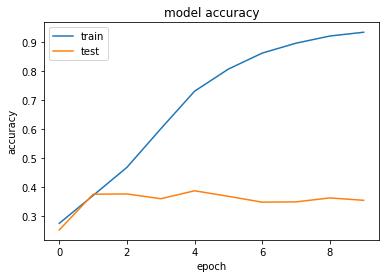

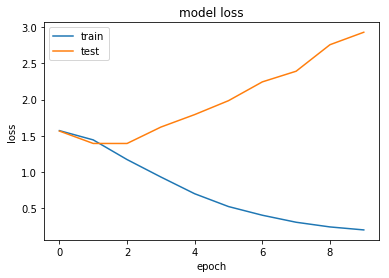

In [37]:
# 7 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.

# TYPE CODE HERE

# plot

import matplotlib.pyplot as plt
%matplotlib inline
# plot accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# prediction
X_test = test_pad
y_test = model.predict(X_test)
y_classes = y_test.argmax(axis=-1)
y_classes.tofile('logreg_lstm_y_test_sst.txt', sep=',')

## 4.3 -- innovate !

In [63]:
from keras.utils import np_utils
X_train = train_pad
y_train = target
y_train = np_utils.to_categorical(y_train, 5)

X_dev = dev_pad
y_dev = dev_target
y_dev = np_utils.to_categorical(y_dev, 5)

In [66]:
# 8 - Open question: find a model that is better on your dev set
#     (e.g: use a 1D ConvNet, use a better classifier, pretrain your lookup tables ..)
#     you will get point if the results on the test set are better: be careful of not overfitting your dev set too much..
#     Attach the output file "XXX_XXX_y_test_sst.txt" to your deliverable.

# TYPE CODE HERE

embed_dim  = 32  # word embedding dimension
nhid       = 64  # number of hidden units in the LSTM
vocab_size = 20000  # size of the vocabulary
n_classes  = 5

model2 = Sequential()
model2.add(Embedding(vocab_size, embed_dim))
model2.add(LSTM(nhid, dropout_W=0.2, dropout_U=0.2)) #, return_sequences=True))
#model2.add(LSTM(nhid, dropout_W=0.2, dropout_U=0.2))
model2.add(Dense(3, activation='softmax'))
model2.add(Reshape((3, 1)))
model2.add(Conv1D(16, 2, activation='relu'))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Flatten())
model2.add(Dense(n_classes, activation='softmax'))

#
loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  'adam' # find the right optimizer
metrics_classif  =  ['categorical_accuracy']

# Observe how easy (but blackboxed) this is in Keras
model2.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model2.summary())


bs = 64
n_epochs = 5

history2 = model2.fit(X_train, y_train, batch_size=bs, nb_epoch=n_epochs, validation_data=(X_dev, y_dev))

# prediction
y_test = model2.predict(X_test)
y_classes = y_test.argmax(axis=-1)
y_classes.tofile('conv1d_lstm_y_test_sst.txt', sep=',')

/Users/Jean/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, dropout=0.2, recurrent_dropout=0.2)`
  from ipykernel import kernelapp as app


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_25 (Embedding)     (None, None, 32)          640000    
_________________________________________________________________
lstm_33 (LSTM)               (None, 64)                24832     
_________________________________________________________________
dense_34 (Dense)             (None, 3)                 195       
_________________________________________________________________
reshape_14 (Reshape)         (None, 3, 1)              0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 2, 16)             48        
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 1, 16)             0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 16)                0         
__________

/Users/Jean/anaconda3/lib/python3.6/site-packages/keras/models.py:944: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 8544 samples, validate on 1101 samples
Epoch 1/5
8544/8544 [==============================] - 16s 2ms/step - loss: 1.5791 - categorical_accuracy: 0.2718 - val_loss: 1.5761 - val_categorical_accuracy: 0.2534
Epoch 2/5
8544/8544 [==============================] - 10s 1ms/step - loss: 1.5678 - categorical_accuracy: 0.2761 - val_loss: 1.5709 - val_categorical_accuracy: 0.2552
Epoch 3/5
8544/8544 [==============================] - 10s 1ms/step - loss: 1.5350 - categorical_accuracy: 0.3312 - val_loss: 1.5403 - val_categorical_accuracy: 0.3306
Epoch 4/5
8544/8544 [==============================] - 10s 1ms/step - loss: 1.4421 - categorical_accuracy: 0.4391 - val_loss: 1.5110 - val_categorical_accuracy: 0.3642
Epoch 5/5
8544/8544 [==============================] - 10s 1ms/step - loss: 1.3232 - categorical_accuracy: 0.4767 - val_loss: 1.5178 - val_categorical_accuracy: 0.3633
